In [1]:
from typing import Optional

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
do_check_rivers = True
do_mask_rivers = True
do_split_rivers = False
do_save_rivers = False

In [3]:
ds = xr.open_dataset('fram_data/norfjords_160m_river_v2+.nc')
grid_ds = xr.open_dataset('fram_data/norfjords_160m_grid_version3.nc')

Add s layers

In [4]:
def add_s_layers(river_ds):

    # Creating new array to fill the gaps
    v_data = np.zeros((5, 175))
    v_add = xr.DataArray(v_data, dims=river_ds['river_Vshape'].dims, coords=river_ds['river_Vshape'].coords)
    temp_data = np.ones((4019, 5, 175)) * 5
    t_add = xr.DataArray(temp_data, dims=river_ds['river_temp'].dims, coords=river_ds['river_temp'].coords)
    salt_data = np.ones((4019, 5, 175))
    s_add = xr.DataArray(salt_data, dims=river_ds['river_salt'].dims, coords=river_ds['river_salt'].coords)
    
    # New ready data arrays
    river_Vshape = xr.concat([v_add, river_ds['river_Vshape']], dim="s_rho")
    river_temp = xr.concat([t_add, river_ds['river_temp']], dim="s_rho")
    river_salt = xr.concat([s_add, river_ds['river_salt']], dim="s_rho")
    
    # Remove old and add new variables with new s_rho=40 dimension
    river_ds = river_ds.drop_dims('s_rho')
    river_ds = river_ds.assign(river_Vshape=river_Vshape, river_temp=river_temp, river_salt=river_salt)

    return river_ds

Check rivers

In [5]:
def check_rivers_runoff(ds, verbose=False, runoff=0):
    river_xi_eta_dir = []
    for i in range(ds.dims['river']):
        river = ds.isel(river=i, river_time=0)
        assert i+1 == int(river.river)
        cell_runoff = (abs(river.river_transport) * river.river_Vshape).max().values
        if cell_runoff >= runoff:
            if verbose:
                print(f"River {i+1} max runoff: {cell_runoff}")
                print(f"Coordinates: {river.river_Xposition}; {river.river_Eposition}")
                print(f"Direction: {river.river_direction} \n")
            river_xi_eta_dir.append((
                int(river.river),
                int(river.river_Xposition.values), 
                int(river.river_Eposition.values),
                int(river.river_direction.values)
            ))
    return river_xi_eta_dir

In [6]:
def check_coords(ds, xi, eta):
    xis = [xi + i for i in range(-5, 6)]
    etas =  [eta + i for i in range(-5, 6)]
    for river_id in ds.river.values:
        river_id = int(river_id-1)
        x_pos = int(ds.river_Xposition[river_id].values)
        y_pos = int(ds.river_Eposition[river_id].values)
        if x_pos in xis and y_pos in etas:
            print(f"Xi: {x_pos}; Eta: {y_pos}")


In [7]:
def gen_rivers_map(ds, grid_ds):
    map_shape = grid_ds.dims['xi_rho'], grid_ds.dims['eta_rho']
    riv_map = np.ones(map_shape)
    for river_id in ds.river.values:
        river_id = int(river_id-1)
        x_pos = int(ds.river_Xposition[river_id].values)
        y_pos = int(ds.river_Eposition[river_id].values)
        riv_map[x_pos, y_pos] = -1 
    
    return riv_map

In [8]:
up_xi = grid_ds.dims['xi_rho'] - 1
up_eta = grid_ds.dims['eta_rho'] - 1


def get_xi_slice(xi, delta):
    return slice(max(min(xi - delta, up_xi), 0), max(min(xi + delta + 1, up_xi), 0))


def get_eta_slice(eta, delta):
    return slice(max(min(eta - delta, up_eta), 0), max(min(eta + delta + 1, up_eta), 0))

In [9]:
def plot_river_estuary_u(river, river_xi, river_eta, river_dir):

    assert river_dir == 0
    mask_u = grid_ds.mask_u.copy()
    plt.figure(figsize=(15, 4))

    xi_slice = get_xi_slice(river_xi, 4)
    eta_slice = get_eta_slice(river_eta, 4)

    plt.subplot(121)
    mask_u.isel(
        xi_u=xi_slice,
        eta_u=eta_slice,
        ).plot()

    mask_u[dict(xi_u=river_xi, eta_u=river_eta)] = np.nan

    plt.subplot(122)
    mask_u.isel(
        xi_u=xi_slice,
        eta_u=eta_slice,
        ).plot()
    # to show the fortran locations
    plt.suptitle(f"River: {river}; Xi: {river_xi+1}; Eta: {river_eta}; Direction: {river_dir}.")
    # plt.suptitle(f"River: {river}; Xi: {river_xi+1}; Eta: {river_eta+1}; Direction: {river_dir}.")


def plot_river_estuary_v(river, river_xi, river_eta, river_dir):

    assert river_dir == 1
    mask_v = grid_ds.mask_v.copy()
    plt.figure(figsize=(15, 4))

    xi_slice = get_xi_slice(river_xi, 4)
    eta_slice = get_eta_slice(river_eta, 4)

    plt.subplot(121)
    mask_v.isel(
        xi_v=xi_slice,
        eta_v=eta_slice,
        ).plot()

    mask_v[dict(xi_v=river_xi, eta_v=river_eta)] = np.nan

    plt.subplot(122)
    mask_v.isel(
        xi_v=xi_slice,
        eta_v=eta_slice,
        ).plot()
    # to show the fortran locations
    plt.suptitle(f"River: {river}; Xi: {river_xi}; Eta: {river_eta+1}; Direction: {river_dir}.")
    # plt.suptitle(f"River: {river}; Xi: {river_xi+1}; Eta: {river_eta+1}; Direction: {river_dir}.")


def plot_river_estuary_rho(river, river_xi, river_eta, river_dir):

    mask_rho = grid_ds.mask_rho.copy()
    plt.figure(figsize=(15, 4))

    plt.subplot(121)
    mask_rho.isel(
        xi_rho=slice(river_xi - 4, river_xi + 5), 
        eta_rho=slice(river_eta - 4, river_eta + 5)
        ).plot()

    mask_rho[dict(xi_rho=river_xi, eta_rho=river_eta)] = np.nan

    plt.subplot(122)
    mask_rho.isel(
        xi_rho=slice(river_xi - 4, river_xi + 5), 
        eta_rho=slice(river_eta - 4, river_eta + 5)
        ).plot()
    # to show the fortran locations
    plt.suptitle(f"River: {river}; Xi: {river_xi+1}; Eta: {river_eta+1}; Direction: {river_dir}.")

In [10]:
def plot_rivers_luv(river_xi_eta_dir):
    """
    Probably, not sure: Due to roms notation where rho points start from zero 
    (so not such points in fortran), eta coordinate in mask_u already "has"
    pythonic coordinates : bullshit - smth probably bad with a rivers forcing.
    https://www.myroms.org/wiki/Grid_Generation

    Args:
        river_xi_eta_dir: a list of river, xi, eta, dir
    """
    for river, xi, eta, direction in river_xi_eta_dir:
        if direction == 0: 
            xi, eta = xi - 1, eta
            plot_river_estuary_u(river, xi, eta, direction)
        else:
            xi, eta = xi, eta - 1
            plot_river_estuary_v(river, xi, eta, direction)


def plot_rivers_lw(river_xi_eta_dir):
    for river, xi, eta, direction in river_xi_eta_dir:
        plot_river_estuary_rho(river, xi-1, eta-1, direction)

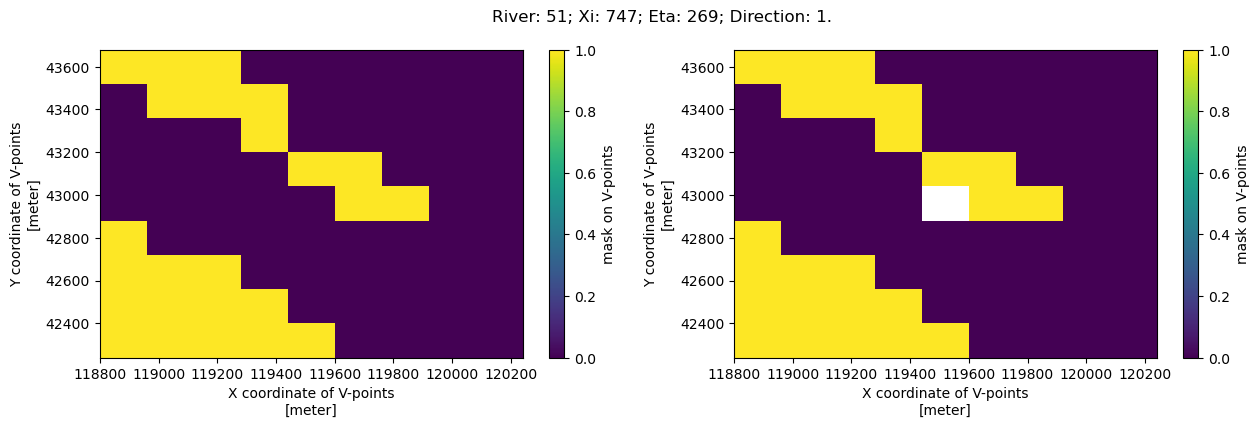

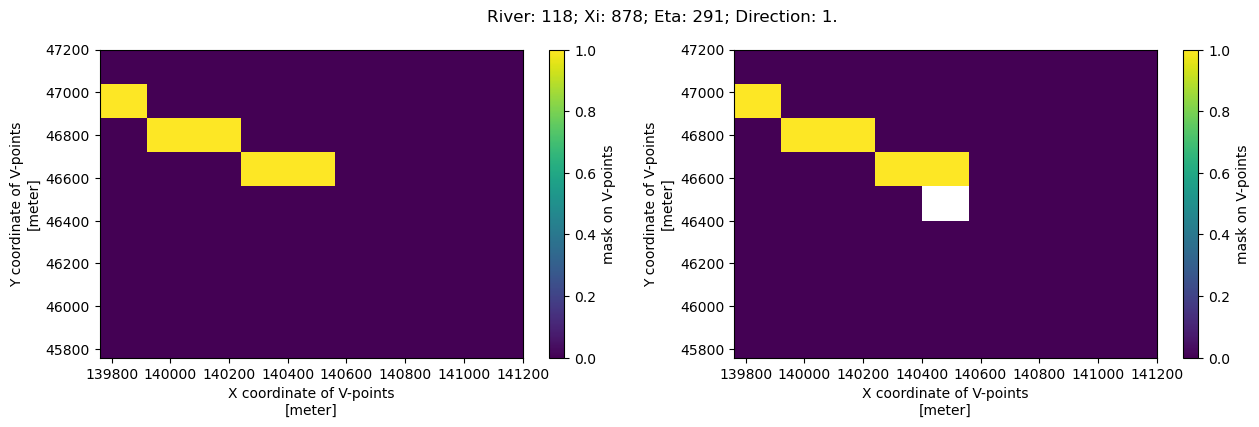

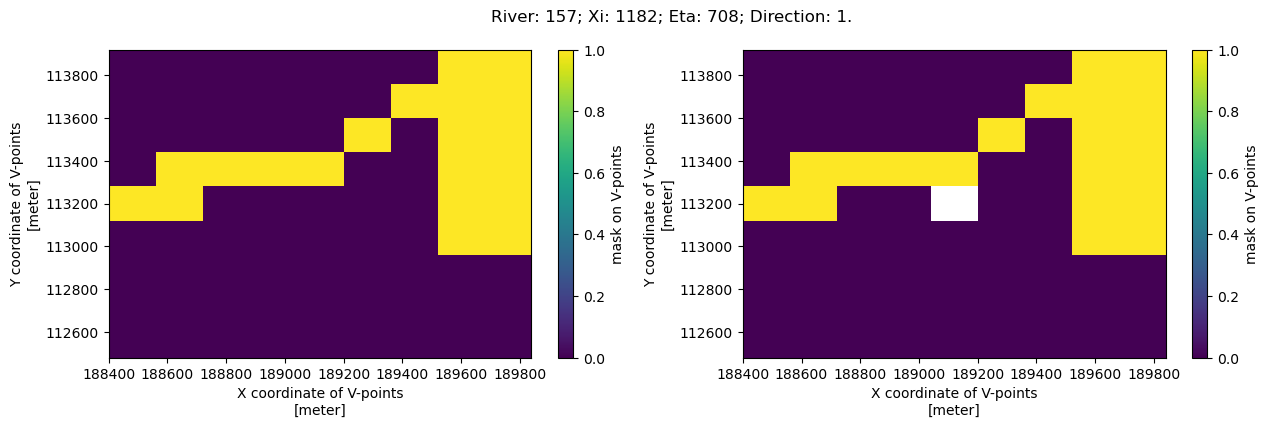

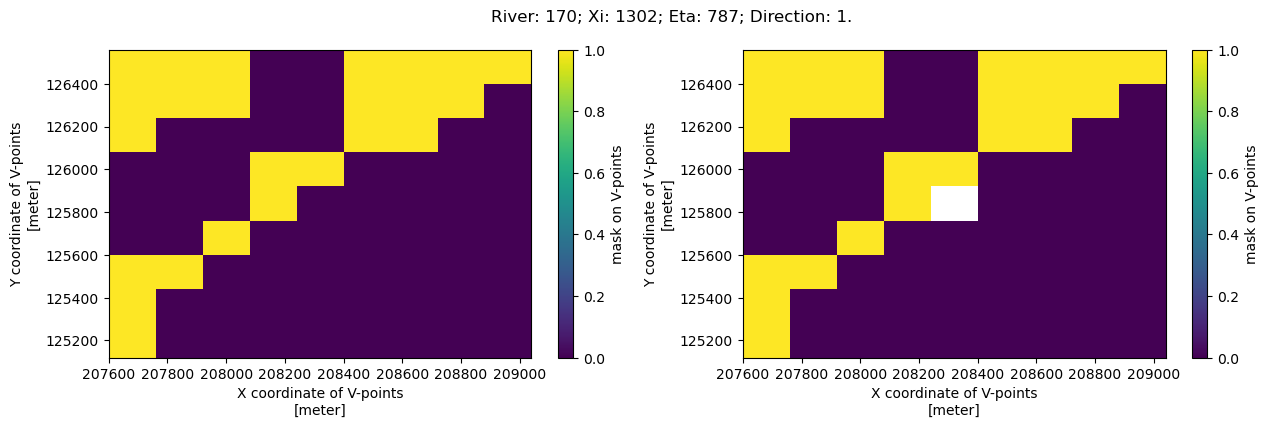

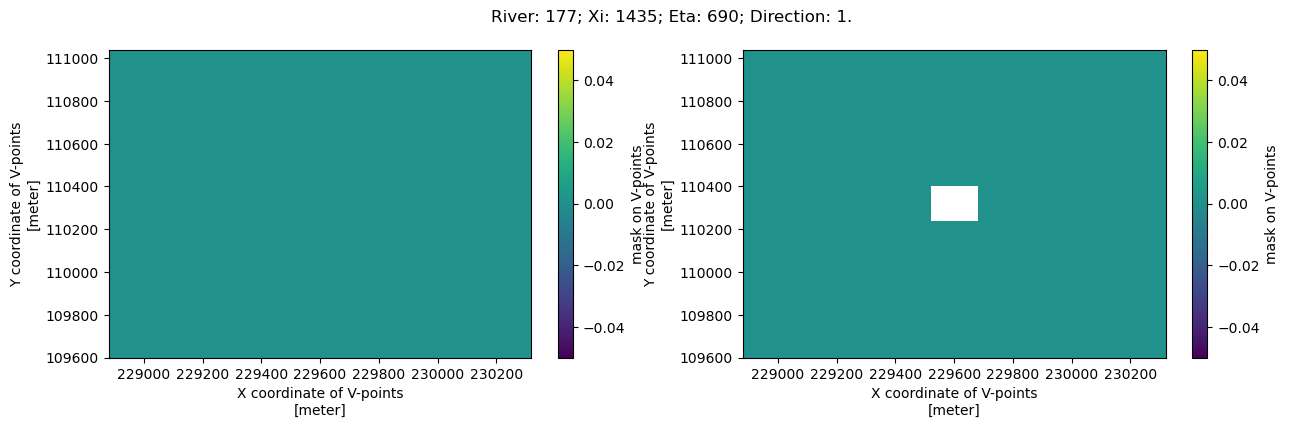

In [11]:
if do_check_rivers:
    river_xi_eta_dir = check_rivers_runoff(ds, verbose=False)

    # rivers = [river - 1 for river, _, _, _ in river_xi_eta_dir]  # assignment use iloc
    # rivers_map = gen_rivers_map(ds, grid_ds)
    # check_coords(ds, 777, 464)
    # a_river = river_xi_eta_dir[0:50]
    # b_river = river_xi_eta_dir[50:100]
    # c_river = river_xi_eta_dir[100:]

    bad_coords = [50, 117, 156, 169, 176]
    bad_rivers = [river_xi_eta_dir[coord] for coord in bad_coords]
    
    plot_rivers_luv(bad_rivers)

Masking

In [12]:
def mask_all_rivers(ds):
    ds['river_transport'].values = np.zeros((4019, 175))
    return ds

In [13]:
def mask_some_rivers(ds, rivers):
    """
    Assignment uses i locations (implicit)
    """

    try:
        ds.river_transport[dict(river=rivers)] = np.zeros((4019, 1))
    except ValueError:
        ds.river_transport[dict(river=rivers)] = np.zeros((4019))

    return ds

In [14]:
if do_mask_rivers:
    new_ds = ds.copy(deep=True)
    for br, bc in zip(bad_rivers, bad_coords):
        new_ds = mask_some_rivers(new_ds, bc)
        print(f"River: {br}")
        print(f"Old: {ds.sel(river=bc+1).river_transport.values}")
        print(f"New: {new_ds.sel(river=bc+1).river_transport.values}\n")

River: (51, 747, 269, 1)
Old: [10.19999981  9.89999962 10.         ...  5.30000019  5.19999981
  5.        ]
New: [0. 0. 0. ... 0. 0. 0.]

River: (118, 878, 291, 1)
Old: [4.         4.5999999  5.         ... 3.5        3.4000001  3.29999995]
New: [0. 0. 0. ... 0. 0. 0.]

River: (157, 1182, 708, 1)
Old: [2.29999995 2.9000001  3.5        ... 2.         2.         1.89999998]
New: [0. 0. 0. ... 0. 0. 0.]

River: (170, 1302, 787, 1)
Old: [6.5999999  8.         9.         ... 5.         4.9000001  4.69999981]
New: [0. 0. 0. ... 0. 0. 0.]

River: (177, 1435, 690, 1)
Old: [ 9.39999962 10.69999981 11.39999962 ...  6.30000019  6.0999999
  5.80000019]
New: [0. 0. 0. ... 0. 0. 0.]



Split rivers

In [15]:
def split_river(
    ds, 
    number: float, 
    dir_swap: bool = False, 
    flux_swap: bool = False,
    f_xi: Optional[float] = None,
    f_eta: Optional[float] = None,
    s_xi: Optional[float] = None,
    s_eta: Optional[float] = None,
    ):
    """
    Decrease flux twice at the current position.
    Adds a new river at the provided position.

    Args:
        ds: Entire dataset to change.
        number: river coordinate number
        dir_swap: river ROMS direction
        flux_swap: multiplies by -1 if True
        f_xi: current river new xi coordinate
        f_eta: current river eta new coordinate
        s_xi: new river xi coordinate
        s_eta: new river eta coordinate

    Returns:
        ds: a new dataset with an additional 'river'.
    """
    directions = {
        0: 1,
        1: 0,
    }

    river_ds = ds.sel(river=number)

    if dir_swap: 
        direction = river_ds.river_direction.values
        river_ds.river_direction.values = directions[int(direction)]

    if_swap = -1 if flux_swap else 1
    river_ds.river_transport.values = if_swap * 1/2 * river_ds.river_transport.values

    if f_xi is not None: 
        river_ds.river_Xposition.values = f_xi
    if f_eta is not None: 
        river_ds.river_Eposition.values = f_eta

    ds.loc[dict(river=number)] = river_ds

    if s_xi is not None: 
        river_ds.river_Xposition.values = s_xi
    if s_eta is not None: 
        river_ds.river_Eposition.values = s_eta

    river_ds.river.values = ds.river[-1].values + 1
    ds = xr.concat([ds, river_ds], dim="river")

    return ds

In [16]:
if do_split_rivers:
    plot_rivers_luv(river_xi_eta_dir)
    plot_rivers_luv(river_xi_eta_dir[0:1])
    
    ds = split_river(ds, number=12., dir_swap=True, flux_swap=True, f_xi=728, f_eta=10, s_xi=728, s_eta=9)
    
    rivers = ds.sel(river=12), ds.isel(river=-1)
    new_river_xi_eta_dir = []
    for river in rivers:
        new_river_xi_eta_dir.append((
            int(river.river),
            int(river.river_Xposition.values), 
            int(river.river_Eposition.values),
            int(river.river_direction.values)
        ))
    
    plot_rivers_luv(new_river_xi_eta_dir)

Save rivers

In [17]:
def save_rivers(ds, name):
    ds.to_netcdf(path=f'fram_data/norfjords_160m_river_{name}.nc', format='NETCDF4')

In [18]:
if do_save_rivers:
    save_rivers(new_ds, "v3")